Sample data:
  ORIGIN_AIRPORT DESTINATION_AIRPORT AIRLINE  HOUR  MONTH  WEATHER_DELAY  \
0            CPH              MIAGRU      NZ    16      1              0   
1            SFO                 BKK      TP     4      4              0   
2            SAN                 LAX      BA    17      6              0   
3           OSLO                 ICN      KL    19      3              0   
4            IAD                 LIS      BA     0      1              0   

   AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  SECURITY_DELAY  SEASON_DELAY  \
0              0                    0               0            20   
1              0                    0               0             5   
2              0                   10               0            10   
3             15                    0               0             5   
4              0                    0               5            20   

   DEPARTURE_DELAY_MINUTES  DEPARTURE_DELAY_FLAG  
0                       23                     1  
1

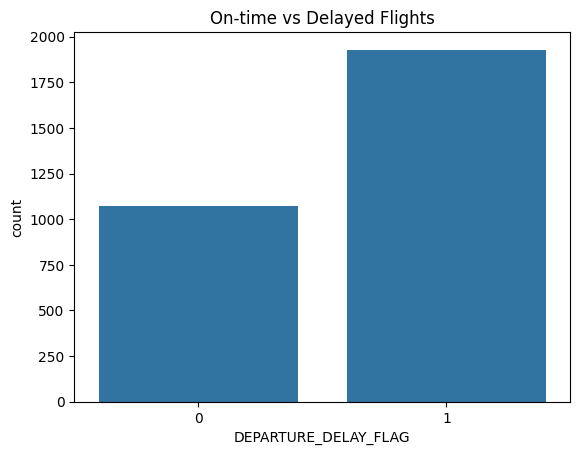

/tmp/ipython-input-1-3425787841.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='HOUR', y='DEPARTURE_DELAY_FLAG', data=df, ci=None)


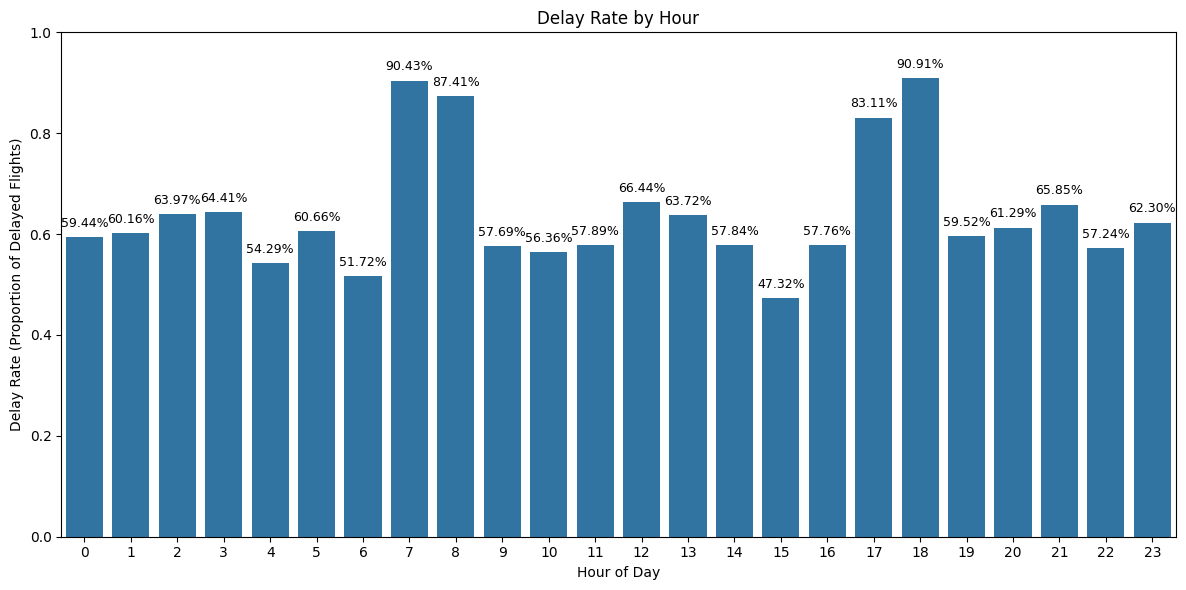

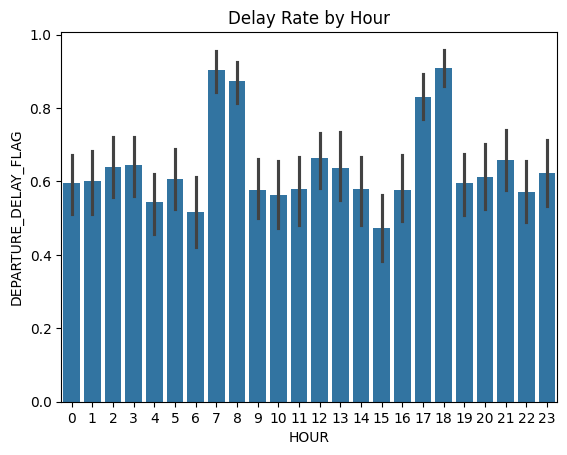

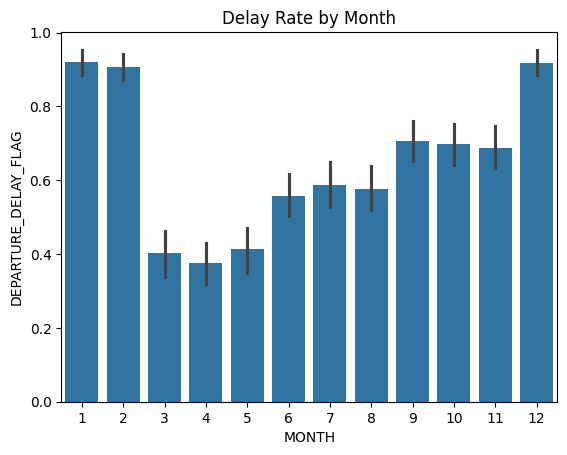

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       197
           1       0.88      0.88      0.88       403

    accuracy                           0.84       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.84      0.84      0.84       600



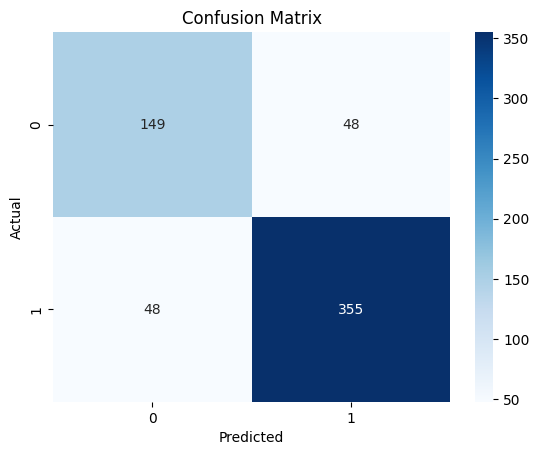

/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a004014d5219f4e580.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import gradio as gr


np.random.seed(50)
random.seed(50)

airports = ['BEY', 'LHR', 'CDG', 'FRA', 'DXB', 'JFK', 'IST', 'AMM', 'CAI', 'MAD', 'AMS', 'SIN', 'HND', 'ORD', 'SVO', 'BKK', 'DEL', 'MIA' 'GRU','YYZ','PEK', 'ICN', 'LAX', 'MEL', 'JNB', 'ZRH', 'EWR', 'MUC', 'FCO', 'DUB', 'BCN', 'VIE', 'CPH', 'HEL', 'ARN', 'OSLO', 'LIS', 'BRU', 'ATH', 'MAN', 'LED', 'SFO', 'SEA', 'DEN', 'IAD', 'PHX', 'LAS', 'BOG',
            'EZE', 'CUN', 'SAN', 'TPE', 'KUL']
airlines = ['MEA', 'THY', 'EK', 'AF', 'LH', 'BA', 'RJ', 'MS', 'AA', 'DL', 'UA', 'SQ', 'QF', 'CX', 'KL', 'IB', 'SA', 'AC', 'NH', 'AZ', 'QR', 'ET', 'OS', 'NZ', 'JL', 'LX', 'TG', 'MH', 'AI', 'CZ', 'TP', 'SU', 'VS', 'FI', 'EY', 'IB', 'VY', 'SK', 'LO', 'W6']

airline_delay_probs = {
'MEA': 0.14, 'THY': 0.11, 'EK': 0.09, 'AF': 0.12, 'LH': 0.08, 'BA': 0.13, 'RJ': 0.15,
'MS': 0.16, 'AA': 0.14, 'DL': 0.10, 'UA': 0.12, 'SQ': 0.07, 'QF': 0.09, 'CX': 0.11, 'KL': 0.08, 'IB': 0.14,
'SA': 0.17, 'AC': 0.10, 'NH': 0.08, 'AZ': 0.13, 'QR': 0.10, 'ET': 0.18, 'OS': 0.13, 'NZ': 0.09, 'JL': 0.08,
'LX': 0.07, 'TG': 0.11, 'MH': 0.14, 'AI': 0.17, 'CZ': 0.13, 'TP': 0.10, 'SU': 0.15, 'VS': 0.12, 'FI': 0.14, 'EY': 0.09,
'VY': 0.16, 'SK': 0.12, 'LO': 0.13, 'W6': 0.14
}

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

def season_delay_effect(season):
    effects = {
        'winter': 20,
        'spring': 5,
        'summer': 10,
        'fall': 15
    }
    return effects.get(season, 5)

def generate_flight_data(n):
    data = []
    for _ in range(n):
        origin = random.choice(airports)
        dest = random.choice(airports)
        while dest == origin:
            dest = random.choice(airports)
        airline = random.choice(airlines)
        hour = np.random.randint(0, 24)
        month = np.random.randint(1, 13)

        weather_severity = np.random.choice([0, 1, 2, 3], p=[0.7, 0.15, 0.1, 0.05])
        airline_delay = 1 if np.random.rand() < airline_delay_probs.get(airline, 0.1) else 0
        late_aircraft_delay = 1 if np.random.rand() < 0.1 else 0
        security_delay = 1 if np.random.rand() < 0.05 else 0

        season = month_to_season(month)
        season_delay = season_delay_effect(season)

        base_delay = 0
        base_delay += weather_severity * 10
        base_delay += airline_delay * 15
        base_delay += late_aircraft_delay * 10
        base_delay += security_delay * 5
        base_delay += season_delay

        if hour in [7, 8, 17, 18]:
            base_delay += np.random.randint(5, 15)

        delay_minutes = max(0, int(base_delay + np.random.normal(0, 5)))
        delayed_flag = 1 if delay_minutes > 15 else 0

        data.append({
            'ORIGIN_AIRPORT': origin,
            'DESTINATION_AIRPORT': dest,
            'AIRLINE': airline,
            'HOUR': hour,
            'MONTH': month,
            'WEATHER_DELAY': weather_severity * 10,
            'AIRLINE_DELAY': airline_delay * 15,
            'LATE_AIRCRAFT_DELAY': late_aircraft_delay * 10,
            'SECURITY_DELAY': security_delay * 5,
            'SEASON_DELAY': season_delay,
            'DEPARTURE_DELAY_MINUTES': delay_minutes,
            'DEPARTURE_DELAY_FLAG': delayed_flag
        })
    return pd.DataFrame(data)

df = generate_flight_data(3000)

print("Sample data:")
print(df.head())

print("\nDelay distribution:")
print(df['DEPARTURE_DELAY_FLAG'].value_counts(normalize=True))

sns.countplot(x='DEPARTURE_DELAY_FLAG', data=df)
plt.title("On-time vs Delayed Flights")
plt.show()

plt.figure(figsize=(12,6))
ax = sns.barplot(x='HOUR', y='DEPARTURE_DELAY_FLAG', data=df, ci=None)
ax.set_title("Delay Rate by Hour")
ax.set_ylabel("Delay Rate (Proportion of Delayed Flights)")
ax.set_ylim(0, 1)
ax.set_xlabel("Hour of Day")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.02,
            f'{height:.2%}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

sns.barplot(x='HOUR', y='DEPARTURE_DELAY_FLAG', data=df)
plt.title("Delay Rate by Hour")
plt.show()

sns.barplot(x='MONTH', y='DEPARTURE_DELAY_FLAG', data=df)
plt.title("Delay Rate by Month")
plt.show()

label_encoders = {}
for col in ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE', 'MONTH']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

feature_cols = ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE', 'HOUR', 'MONTH',
                'WEATHER_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'SECURITY_DELAY', 'SEASON_DELAY']
X = df[feature_cols]
y = df['DEPARTURE_DELAY_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

joblib.dump(clf, "flight_delay_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

def parse_delay_reasons(text):
    text = text.lower()
    weather_map = {
        "volcano": 30,
        "volcano eruption": 30,
        "volcanic ash": 30,
        "heavy rain": 25,
        "storm": 25,
        "thunderstorm": 25,
        "hail": 25,
        "rain": 15,
        "showers": 15,
        "fog": 10,
        "mist": 10,
        "haze": 10,
        "snow": 25,
        "clear": 0,
        "sunny": 0,
        "bright": 0
    }
    weather_delay = 5

    for k, v in weather_map.items():
        if k in text:
            weather_delay = v
            break

    airline_delay = 0
    if any(kw in text for kw in ["airline delay", "crew delay", "maintenance", "technical issue", "strike"]):
        airline_delay = 15

    late_aircraft_delay = 0
    if "late aircraft" in text:
        late_aircraft_delay = 10

    security_delay = 0
    if any(kw in text for kw in ["security delay", "security check", "security issue", "security problem"]):
        security_delay = 5

    atc_delay = 0
    if any(kw in text for kw in ["air traffic control", "atc delay", "air traffic delay"]):
        atc_delay = 10

    war_keywords = ["war", "conflict", "bombing", "attack", "terrorism", "strike", "invasion"]
    war_flag = any(kw in text for kw in war_keywords)

    total_weather_delay = weather_delay + atc_delay
    return total_weather_delay, airline_delay, late_aircraft_delay, security_delay, war_flag


def parse_user_message(message):
    origin = re.search(r'from (\w+)', message, re.I)
    destination = re.search(r'to (\w+)', message, re.I)
    hour_12 = re.search(r'(\d{1,2}) ?(am|pm)', message, re.I)
    hour_24 = re.search(r'at (\d{1,2}):?(\d{2})?', message, re.I)
    airline = re.search(r'on (\w+)', message, re.I)
    month_search = re.search(r'in (\w+)', message, re.I)

    if hour_12:
        hour = int(hour_12.group(1))
        if hour_12.group(2).lower() == 'pm' and hour != 12:
            hour += 12
        elif hour_12.group(2).lower() == 'am' and hour == 12:
            hour = 0
    elif hour_24:
        hour = int(hour_24.group(1))
    else:
        hour = 12

    month_map = {
        'january': 1, 'february': 2, 'march': 3,
        'april': 4, 'may': 5, 'june': 6,
        'july': 7, 'august': 8, 'september': 9,
        'october': 10, 'november': 11, 'december': 12
    }
    if month_search:
        month = month_map.get(month_search.group(1).lower(), 1)
    else:
        month = 1

    weather_delay, airline_delay, late_aircraft_delay, security_delay, war_flag = parse_delay_reasons(message)
    season_delay = season_delay_effect(month_to_season(month))

    return {
        "ORIGIN_AIRPORT": origin.group(1).upper() if origin else "BEY",
        "DESTINATION_AIRPORT": destination.group(1).upper() if destination else "LHR",
        "HOUR": hour,
        "MONTH": month,
        "AIRLINE": airline.group(1).upper() if airline else "MEA",
        "WEATHER_DELAY": weather_delay,
        "AIRLINE_DELAY": airline_delay,
        "LATE_AIRCRAFT_DELAY": late_aircraft_delay,
        "SECURITY_DELAY": security_delay,
        "SEASON_DELAY": season_delay,
        "WAR_FLAG": war_flag
    }

def predict_delay(message):
    try:
        features = parse_user_message(message)
        if features.get("WAR_FLAG", False):
            dest = features.get("DESTINATION_AIRPORT", "Unknown")
            return f"Flight to {dest} is canceled due to war/conflict in the destination country."

        df_input = pd.DataFrame([features])

        for col in ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE', 'MONTH']:
            le = label_encoders[col]
            val = df_input.at[0, col]
            if val not in le.classes_:
                return f"Sorry, I don't recognize {col.lower()} '{val}'. Please try a valid code."
            df_input[col] = le.transform([val])

        df_input['HOUR'] = pd.to_numeric(df_input['HOUR'])

        feature_order = ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE', 'HOUR', 'MONTH',
                         'WEATHER_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'SECURITY_DELAY', 'SEASON_DELAY']
        df_input = df_input[feature_order]

        pred = clf.predict(df_input)[0]
        prob = clf.predict_proba(df_input)[0][1]

        if pred == 1:
            return f"There is a {prob*100:.1f}% chance your flight will be delayed."
        else:
            return "Your flight is likely to be on time."
    except Exception as e:
        return f"Sorry, couldn't understand your input. Error: {str(e)}"
def chatbot_response_with_weather(message, history):
    greetings = ["hello", "hi", "hey", "goodmorning", "good afternoon", "good evening"]
    farewells = ["bye", "goodbye", "see you", "thanks", "thank you", "thank"]
    lower_msg = message.lower()

    if len(history) == 0 or any(greet in lower_msg for greet in greetings):
        return ("Hello! I'm your Lebanese Flight Delay Predictor bot.\n"
                "You can tell me things like:\n"
                "'from BEY to LHR at 3pm on MEA in March with heavy rain'\n"
                "Include weather, delays, month, or conflicts for best predictions.")
    if any(farewell in lower_msg for farewell in farewells):
        return "You're very welcome! If you have more questions later, just ask. Safe travels! ✈️"
    try:
        response = predict_delay(message)
        if "Sorry" in response:
            return ("Hmm, I couldn't fully understand your request. "
                    "Could you please check your message and try again? ")
        else:
            return response
    except Exception as e:
        return ("Oops! Something went wrong on my side. "
                "Please try again later or rephrase your question.")

chat = gr.ChatInterface(fn=chatbot_response_with_weather, title="Lebanese Flight Delay Predictor Bot")
chat.launch(share=True)
